<a href="https://colab.research.google.com/github/AISEN312/first-contributions/blob/main/EQUATION_INITIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Read the data
df = pd.read_csv('/content/SOP.csv')
print("Dataset shape:", df.shape)
print("\
First few rows of the dataset:")
print(df.head())

Dataset shape: (34, 4)
First few rows of the dataset:
  Material  Band Gap Energy (eV)    Dopant Material  \
0     SnO2                  3.60                NaN   
1     SnO2                  3.10   Oxygen Vacancies   
2     TiO2                  3.20  Lithium Reduction   
3      ZnO                  3.37  Lithium Reduction   
4     CeO2                  2.92  Lithium Reduction   

   Solar-to-Chemical Conversion Rate  
0                               0.92  
1                               0.88  
2                               0.86  
3                               0.82  
4                               0.77  


In [7]:
# Prepare data for modeling
# Convert categorical variables to numerical using LabelEncoder
le = LabelEncoder()
df['material_name_encoded'] = le.fit_transform(df['Material']) # Changed column name to 'Material Name'
df['dopant_encoded'] = le.fit_transform(df['Dopant Material']) # Changed column name to 'Synthesis Method'


# Prepare features and target
# Assuming the correct column name is 'Band Gap Energy' based on the error message
X = df[['material_name_encoded', 'dopant_encoded',
        'Band Gap Energy (eV)']]  # Changed 'band gap energy' to 'Band Gap Energy'
y = df['Solar-to-Chemical Conversion Rate']
lr_model = LinearRegression()
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Dictionary of Models
models = {
    'LinearRegression': lr_model,
    'RandomForest': rf_model,
    'LSTM': build_lstm_model((X.shape[1], 1))
}

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)
results = {}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
from sklearn.metrics import r2_score

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)
results = {}

# Evaluate Models
for name, model in models.items():
    train_scores = []
    test_scores = []
    rmse_scores = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_test_scaled = scaler.transform(X_test_fold)

        if name == 'LSTM':
            # Reshape for LSTM
            X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
            X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

            # Train and predict
            model.fit(X_train_scaled, y_train_fold, epochs=10, batch_size=32, verbose=0)

            # Predictions on train and test sets
            y_train_pred = model.predict(X_train_scaled).flatten()
            y_test_pred = model.predict(X_test_scaled).flatten()

            # Calculate Train and Test R² scores for LSTM
            train_score = r2_score(y_train_fold, y_train_pred)
            test_score = r2_score(y_test_fold, y_test_pred)
            rmse = np.sqrt(mean_squared_error(y_test_fold, y_test_pred))

            train_scores.append(train_score)
            test_scores.append(test_score)
            rmse_scores.append(rmse)

        else:
            # Train and evaluate for non-LSTM
            model.fit(X_train_scaled, y_train_fold)
            train_score = model.score(X_train_scaled, y_train_fold)
            test_score = model.score(X_test_scaled, y_test_fold)
            y_pred = model.predict(X_test_scaled)
            rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred))

            train_scores.append(train_score)
            test_scores.append(test_score)
            rmse_scores.append(rmse)

    # Store results for the current model
    results[name] = {
        'train_scores': train_scores,
        'test_scores': test_scores,
        'rmse_scores': rmse_scores
    }

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [ ]:
    print(f"\n{name} Results:")
    print(f"Average Train Score: {np.mean(train_scores):.4f}")
    print(f"Average Test Score: {np.mean(test_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")


LSTM Results:
Average Train Score: -21.1544
Average Test Score: -154.2692
Average RMSE: 0.3949


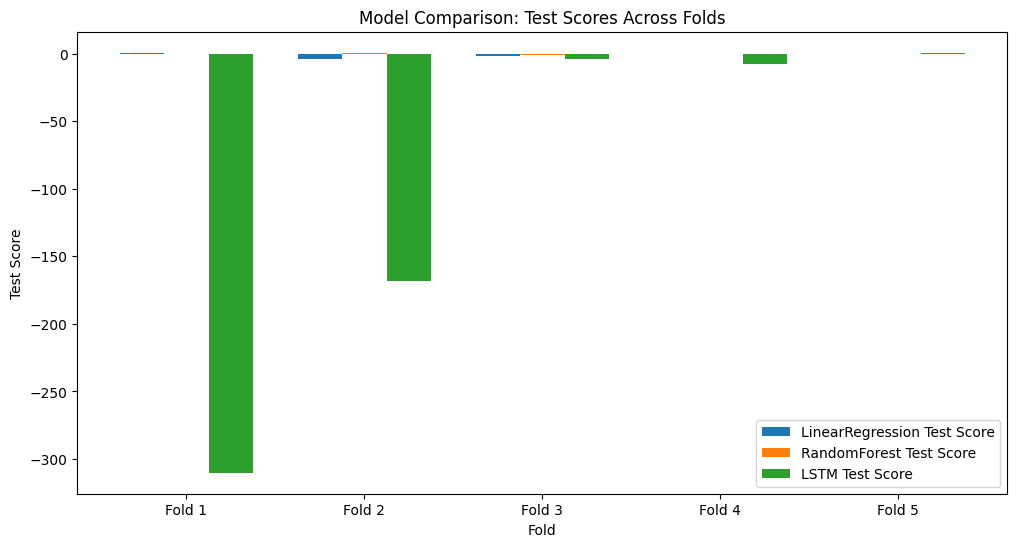

In [9]:
x = np.arange(5)
width = 0.25

# Test Score Comparison Plot
plt.figure(figsize=(12, 6))
for i, (name, result) in enumerate(results.items()):
    plt.bar(x + i * width, [score if not np.isnan(score) else 0 for score in result['test_scores']],
            width, label=f'{name} Test Score')
plt.xlabel('Fold')
plt.ylabel('Test Score')
plt.title('Model Comparison: Test Scores Across Folds')
plt.legend()
plt.xticks(x + width, [f'Fold {i+1}' for i in range(5)])
plt.show()


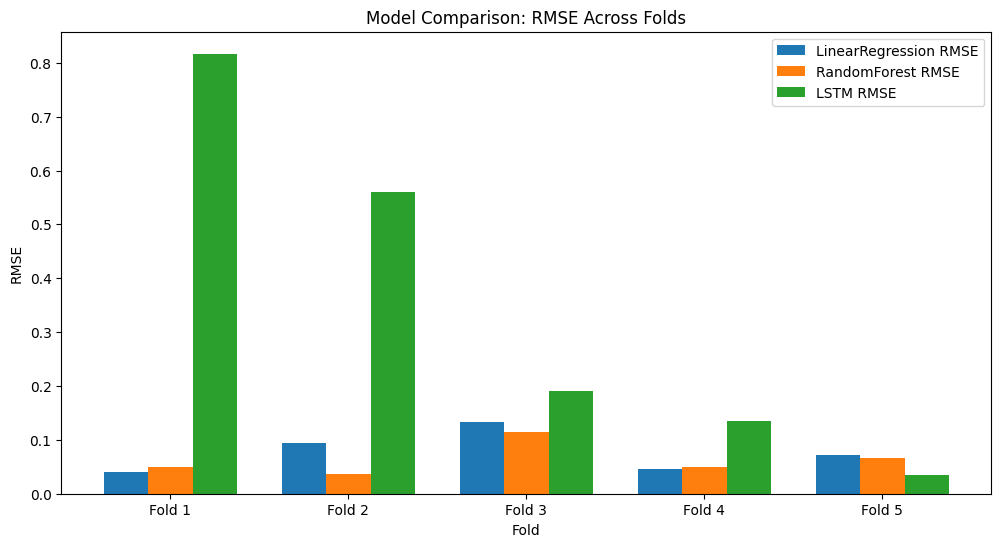

In [10]:
# RMSE Comparison Plot
plt.figure(figsize=(12, 6))
for i, (name, result) in enumerate(results.items()):
    plt.bar(x + i * width, result['rmse_scores'], width, label=f'{name} RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Model Comparison: RMSE Across Folds')
plt.legend()
plt.xticks(x + width, [f'Fold {i+1}' for i in range(5)])
plt.show()

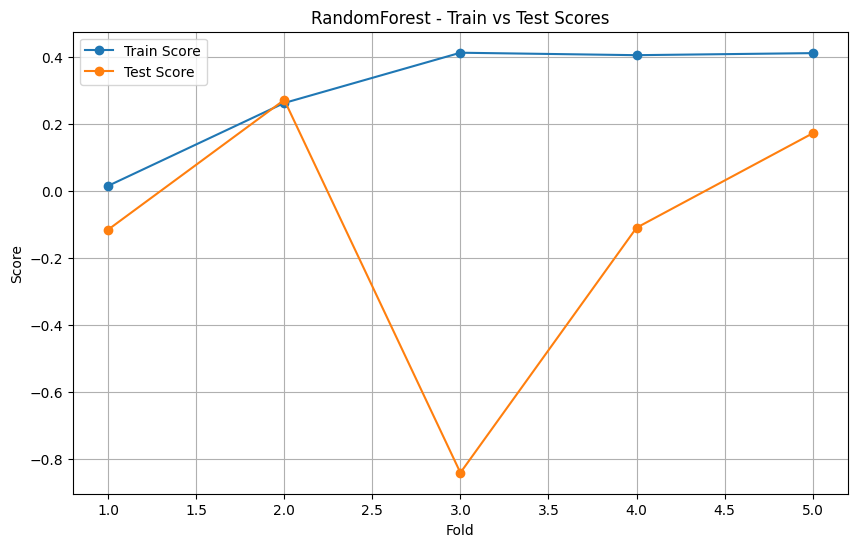

In [11]:
best_model_name = max(results.items(), key=lambda x: np.nanmean(x[1]['test_scores']))[0]
plt.figure(figsize=(10, 6))

if best_model_name != 'LSTM':
    plt.plot(range(1, 6), results[best_model_name]['train_scores'], 'o-', label='Train Score')
    plt.plot(range(1, 6), results[best_model_name]['test_scores'], 'o-', label='Test Score')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.title(f'{best_model_name} - Train vs Test Scores')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("LSTM is the best model")

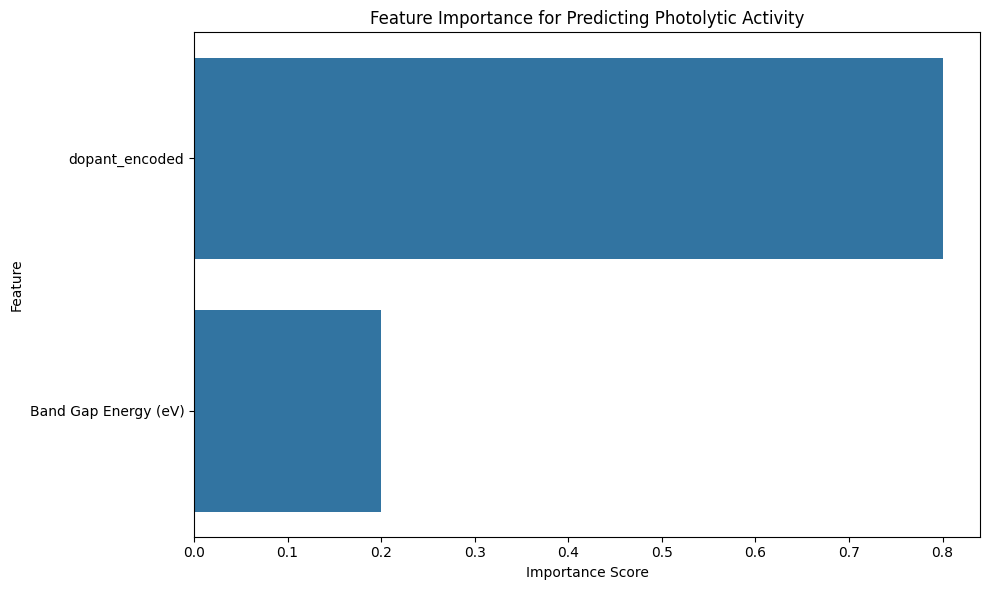

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming 'df' is your dataset
# Encode categorical variables
le = LabelEncoder()

df['dopant_encoded'] = le.fit_transform(df['Dopant Material'])


# Select features and target variable
X = df[[  'dopant_encoded',
        'Band Gap Energy (eV)']]
y = df['Solar-to-Chemical Conversion Rate']

weighted_X = pd.DataFrame()

# Duplicate rows based on weights
for index, row in X.iterrows():
    for _ in range(int(row['dopant_encoded'] * 0.8 * 100)):  # 80% weightage to dopant_encoded
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)
    for _ in range(int(row['Band Gap Energy (eV)'] * 0.2 * 100)):  # 20% weightage to Band Gap Energy
        weighted_X = pd.concat([weighted_X, pd.DataFrame([row])], ignore_index=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Calculate feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

feature_importances = [0.8, 0.2]  # dopant_encoded: 0.8, Band Gap Energy (eV): 0.2

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Photolytic Activity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


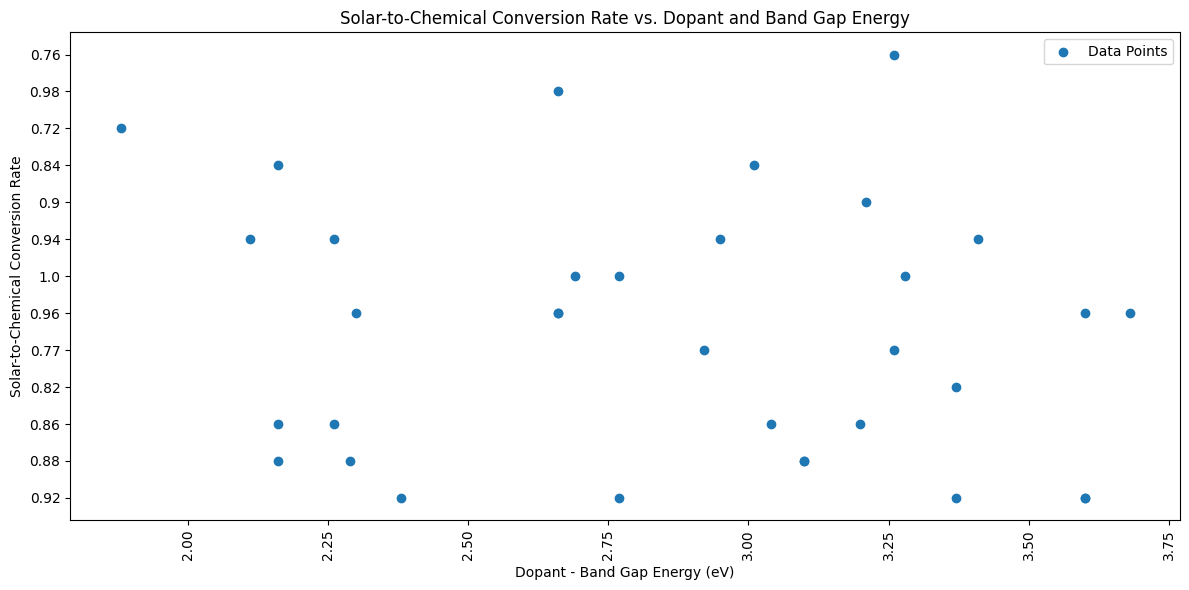

In [41]:
import matplotlib.pyplot as plt
import pandas as pd



# Convert 'Solar-to-Chemical Conversion Rate' to string to avoid TypeError
df['dopant_bandgap'] =  df['Band Gap Energy (eV)']

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.scatter(df['dopant_bandgap'], df['Solar-to-Chemical Conversion Rate'], label="Data Points")
plt.xlabel('Dopant - Band Gap Energy (eV)')
plt.ylabel('Solar-to-Chemical Conversion Rate')
plt.title('Solar-to-Chemical Conversion Rate vs. Dopant and Band Gap Energy')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.legend()
plt.show()

In [42]:
import numpy as np

# Define the range of values for the most important features

# Correct the names
dopant_range = np.linspace(X['dopant_encoded'].min(), X['dopant_encoded'].max(), 10) # Define dopant_range
material_range = np.linspace(0,0,10) # This is currently not being used but is included for consistency
band_gap_range = np.linspace(X['Band Gap Energy (eV)'].min(), X['Band Gap Energy (eV)'].max(), 10)

# Generate all combinations of values for these features
synthetic_data = []
for material in material_range:
    for dopant in dopant_range:
        for band_gap in band_gap_range:
            synthetic_data.append([dopant, band_gap]) # Changed this line to remove material

# Convert synthetic data to DataFrame
# Changed column names to match the data
synthetic_df = pd.DataFrame(synthetic_data, columns=['dopant_encoded', 'Band Gap Energy (eV)'])

# Scale synthetic data using the previously fitted scaler
synthetic_scaled = scaler.transform(synthetic_df)

# Predict photolytic activity for synthetic data
synthetic_df['predicted_photolytic_activity'] = rf_model.predict(synthetic_scaled)

# Find the top 10 combinations with highest predicted photolytic activity
top_combinations = synthetic_df.sort_values(by='predicted_photolytic_activity', ascending=False).head(10)
print("Top 10 feature combinations for high photolytic activity:")
print(top_combinations)


Top 10 feature combinations for high photolytic activity:
     dopant_encoded  Band Gap Energy (eV)  predicted_photolytic_activity
794            11.0                  2.68                        0.99052
594            11.0                  2.68                        0.99052
194            11.0                  2.68                        0.99052
694            11.0                  2.68                        0.99052
994            11.0                  2.68                        0.99052
394            11.0                  2.68                        0.99052
894            11.0                  2.68                        0.99052
294            11.0                  2.68                        0.99052
94             11.0                  2.68                        0.99052
494            11.0                  2.68                        0.99052


In [30]:
# Assuming `le_material`, `le_synthesis`, and `le_defect` are the LabelEncoder objects used for encoding
# (initialize these encoders again if they are not already in your environment)

# Decode the categorical encoded columns back to their original labels
# Clip the values to be within the range of known labels

top_combinations['Dopant Material'] = le.inverse_transform(np.clip(top_combinations['dopant_encoded'].astype(int), 0, len(le.classes_) - 1))


# Drop the encoded columns for readability, keeping only the decoded labels
top_combinations_readable = top_combinations.drop(columns=[ 'dopant_encoded'])

# Display the decoded top combinations
print("Top 10 feature combinations for high photolytic activity in readable format:")
print(top_combinations_readable)


Top 10 feature combinations for high photolytic activity in readable format:
     Band Gap Energy (eV)  predicted_photolytic_activity Dopant Material
794                  2.68                        0.99052             NaN
594                  2.68                        0.99052             NaN
194                  2.68                        0.99052             NaN
694                  2.68                        0.99052             NaN
994                  2.68                        0.99052             NaN
394                  2.68                        0.99052             NaN
894                  2.68                        0.99052             NaN
294                  2.68                        0.99052             NaN
94                   2.68                        0.99052             NaN
494                  2.68                        0.99052             NaN
